In [1]:
import sys
import os
import numpy as np
import pandas as pd
from qnorm import quantile_normalize

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr


In [2]:
#Load quality table for eCLIP experiments

quality_df = pd.read_csv("/home/jlinder/analysis/eclip/encode/eclip_yeo_list.csv", sep=',')[['ENCODE Accession #', 'Non-PCR duplicate, uniquely mapped read # - Rep1', 'Non-PCR duplicate, uniquely mapped read # - Rep2']]
quality_df = quality_df.rename(columns={
    'ENCODE Accession #' : 'enc_id',
    'Non-PCR duplicate, uniquely mapped read # - Rep1' : 'n_reads_rep_1',
    'Non-PCR duplicate, uniquely mapped read # - Rep2' : 'n_reads_rep_2',
}).copy().reset_index(drop=True)

quality_df['n_reads_avg'] = (quality_df['n_reads_rep_1'] + quality_df['n_reads_rep_2']) // 2

quality_dict = {}
for _, row in quality_df.iterrows() :
    quality_dict[row['enc_id']] = row['n_reads_avg']


In [5]:
#Read accuracies

experiment_names = [
    'clip_encode_k562',
    'clip_encode_hepg2',
    'clip_goodarzi',
]

model_dirs = [
    'models',
    'models_retry1',
    'models_retry2',
]

fold_index = [0, 1]
cross_index = [0]

experiment_dict = {}

for experiment_name in experiment_names :
    
    print("-- " + experiment_name + " --")

    acc_dfs = []

    for fold_ix in fold_index :
        for cross_ix in cross_index :
            for model_dir in model_dirs :
                acc_df = pd.read_csv(model_dir + '/f' + str(fold_ix) + 'c' + str(cross_ix) + '/testg_' + experiment_name + '-0/acc.txt', index_col=0, sep='\t')
                acc_dfs.append(acc_df)

    print("len(acc_dfs) = " + str(len(acc_dfs)))
    
    targets_df = pd.read_csv('targets_human.txt', index_col=0, sep='\t')
    
    enc_dict = {}
    for _, row in targets_df.iterrows() :
        if row['source'] == 'encode' and 'CLIP:' in row['description'] and row['identifier'][:-1] not in enc_dict :
            enc_dict[row['identifier'][:-1]] = row['file'].split("clip/encode/")[1].split("/")[0]

    #Aggregate metrics

    r = np.zeros((len(acc_dfs[0]), len(acc_dfs)), dtype='float32')
    r_norm = np.zeros((len(acc_dfs[0]), len(acc_dfs)), dtype='float32')
    r_within = np.zeros((len(acc_dfs[0]), len(acc_dfs)), dtype='float32')
    n_reads = np.zeros((len(acc_dfs[0]), 1), dtype='float32')

    for rep_ix in range(len(acc_dfs)) :
        r[: , rep_ix] = acc_dfs[rep_ix]['pearsonr'].values
        r_norm[: , rep_ix] = acc_dfs[rep_ix]['pearsonr_norm'].values
        r_within[: , rep_ix] = acc_dfs[rep_ix]['pearsonr_gene'].values
        
    for assay_ix, [_, row] in enumerate(acc_dfs[0].iterrows()) :
        if row['identifier'][:-1] in enc_dict and enc_dict[row['identifier'][:-1]] in quality_dict :
            n_reads[assay_ix] = quality_dict[enc_dict[row['identifier'][:-1]]]
        else :
            n_reads[assay_ix] = np.nan

    print("r.shape = " + str(r.shape))
    print("r_norm.shape = " + str(r_norm.shape))
    print("r_within.shape = " + str(r_within.shape))
    print("n_reads.shape = " + str(n_reads.shape))
    
    experiment_dict[experiment_name] = [
        r,
        r_norm,
        r_within,
        n_reads,
    ]

print("len(experiment_dict) = " + str(len(experiment_dict)))


-- clip_encode_k562 --
len(acc_dfs) = 6
r.shape = (20, 6)
r_norm.shape = (20, 6)
r_within.shape = (20, 6)
n_reads.shape = (20, 1)
-- clip_encode_hepg2 --
len(acc_dfs) = 6
r.shape = (11, 6)
r_norm.shape = (11, 6)
r_within.shape = (11, 6)
n_reads.shape = (11, 1)
-- clip_goodarzi --
len(acc_dfs) = 6
r.shape = (13, 6)
r_norm.shape = (13, 6)
r_within.shape = (13, 6)
n_reads.shape = (13, 1)
len(experiment_dict) = 3


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


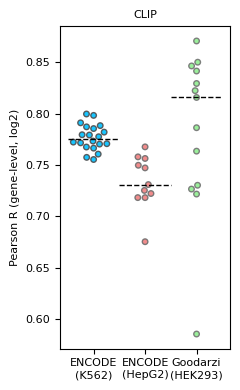

In [6]:
#Plot pearsonr metric

acc_vals = [
    np.mean(experiment_dict['clip_encode_k562'][0], axis=-1),
    np.mean(experiment_dict['clip_encode_hepg2'][0], axis=-1),
    np.mean(experiment_dict['clip_goodarzi'][0], axis=-1),
]

model_colors = [
    'deepskyblue',
    'lightcoral',
    'lightgreen',
]

data_names = [
    'ENCODE\n(K562)',
    'ENCODE\n(HepG2)',
    'Goodarzi\n(HEK293)',
]

metric_col = 'Pearson R (gene-level, log2)'

ymin = None
ymax = None

f = plt.figure(figsize=(2.5, 4))

#sns.boxplot(data=acc_vals, palette=model_colors, fliersize=0., whis=(5, 95))
#sns.stripplot(data=acc_vals, palette=model_colors, alpha=0.9, s=4, zorder=-1)
sns.swarmplot(data=acc_vals, palette=model_colors, alpha=0.9, s=4, color='black', linewidth=1, zorder=-1)

for j in range(len(acc_vals)) :
    median_val = np.nanmedian(acc_vals[j])
    plt.plot([j-0.5, j+0.5], [median_val, median_val], linewidth=1, linestyle='--', color='black')

plt.xticks(np.arange(len(data_names), dtype='int32'), data_names, fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel(metric_col, fontsize=8)

plt.title("CLIP", fontsize=8)

if ymin is not None and ymax is not None :
    plt.ylim(ymin, ymax)

plt.tight_layout()

plt.savefig('clip_gene_pearsonr_3_reps.eps')

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


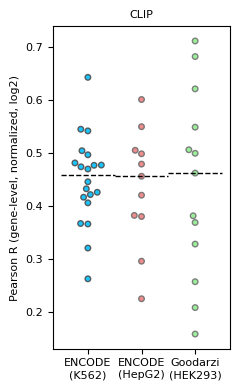

In [7]:
#Plot pearsonr (norm) metric

acc_vals = [
    np.mean(experiment_dict['clip_encode_k562'][1], axis=-1),
    np.mean(experiment_dict['clip_encode_hepg2'][1], axis=-1),
    np.mean(experiment_dict['clip_goodarzi'][1], axis=-1),
]

model_colors = [
    'deepskyblue',
    'lightcoral',
    'lightgreen',
]

data_names = [
    'ENCODE\n(K562)',
    'ENCODE\n(HepG2)',
    'Goodarzi\n(HEK293)',
]

metric_col = 'Pearson R (gene-level, normalized, log2)'

ymin = None
ymax = None

f = plt.figure(figsize=(2.5, 4))

#sns.boxplot(data=acc_vals, palette=model_colors, fliersize=0., whis=(5, 95))
#sns.stripplot(data=acc_vals, palette=model_colors, alpha=0.9, s=4, zorder=-1)
sns.swarmplot(data=acc_vals, palette=model_colors, alpha=0.9, s=4, color='black', linewidth=1, zorder=-1)

for j in range(len(acc_vals)) :
    median_val = np.nanmedian(acc_vals[j])
    plt.plot([j-0.5, j+0.5], [median_val, median_val], linewidth=1, linestyle='--', color='black')

plt.xticks(np.arange(len(data_names), dtype='int32'), data_names, fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel(metric_col, fontsize=8)

plt.title("CLIP", fontsize=8)

if ymin is not None and ymax is not None :
    plt.ylim(ymin, ymax)

plt.tight_layout()

plt.savefig('clip_gene_pearsonr_norm_3_reps.eps')

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


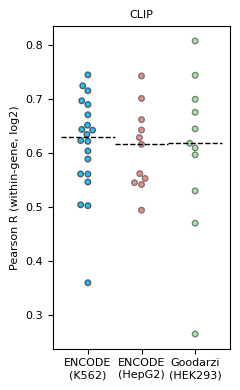

In [8]:
#Plot within-gene pearsonr metric

acc_vals = [
    np.mean(experiment_dict['clip_encode_k562'][2], axis=-1),
    np.mean(experiment_dict['clip_encode_hepg2'][2], axis=-1),
    np.mean(experiment_dict['clip_goodarzi'][2], axis=-1),
]

model_colors = [
    'deepskyblue',
    'lightcoral',
    'lightgreen',
]

data_names = [
    'ENCODE\n(K562)',
    'ENCODE\n(HepG2)',
    'Goodarzi\n(HEK293)',
]

metric_col = 'Pearson R (within-gene, log2)'

ymin = None
ymax = None

f = plt.figure(figsize=(2.5, 4))

#sns.boxplot(data=acc_vals, palette=model_colors, fliersize=0., whis=(5, 95))
#sns.stripplot(data=acc_vals, palette=model_colors, alpha=0.9, s=4, zorder=-1)
sns.swarmplot(data=acc_vals, palette=model_colors, alpha=0.9, s=4, color='black', linewidth=1, zorder=-1)

for j in range(len(acc_vals)) :
    median_val = np.nanmedian(acc_vals[j])
    plt.plot([j-0.5, j+0.5], [median_val, median_val], linewidth=1, linestyle='--', color='black')

plt.xticks(np.arange(len(data_names), dtype='int32'), data_names, fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel(metric_col, fontsize=8)

plt.title("CLIP", fontsize=8)

if ymin is not None and ymax is not None :
    plt.ylim(ymin, ymax)

plt.tight_layout()

plt.savefig('clip_within_pearsonr_3_reps.eps')

plt.show()


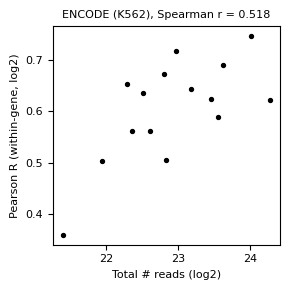

In [9]:
#Compare test set performance (within-gene) to CLIP read depth

x_val = np.log2(experiment_dict['clip_encode_k562'][3])
y_val = np.mean(experiment_dict['clip_encode_k562'][2], axis=-1)

keep_index = np.nonzero(~np.isnan(x_val))[0]

x_val = x_val[keep_index]
y_val = y_val[keep_index]

r_val = spearmanr(x_val, y_val)[0]

f = plt.figure(figsize=(3, 3))

plt.scatter(x_val, y_val, color='black', s=8)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.xlabel("Total # reads (log2)", fontsize=8)
plt.ylabel("Pearson R (within-gene, log2)", fontsize=8)

plt.title('ENCODE (K562), Spearman r = ' + str(round(r_val, 3)), fontsize=8)

plt.tight_layout()

plt.savefig('clip_depth_k562_3_reps.eps')

plt.show()


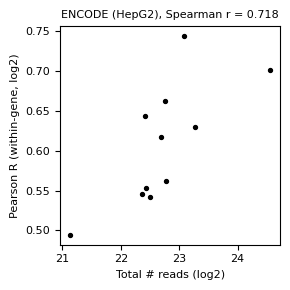

In [10]:
#Compare test set performance (within-gene) to CLIP read depth

x_val = np.log2(experiment_dict['clip_encode_hepg2'][3])
y_val = np.mean(experiment_dict['clip_encode_hepg2'][2], axis=-1)

keep_index = np.nonzero(~np.isnan(x_val))[0]

x_val = x_val[keep_index]
y_val = y_val[keep_index]

r_val = spearmanr(x_val, y_val)[0]

f = plt.figure(figsize=(3, 3))

plt.scatter(x_val, y_val, color='black', s=8)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.xlabel("Total # reads (log2)", fontsize=8)
plt.ylabel("Pearson R (within-gene, log2)", fontsize=8)

plt.title('ENCODE (HepG2), Spearman r = ' + str(round(r_val, 3)), fontsize=8)

plt.tight_layout()

plt.savefig('clip_depth_hepg2_3_reps.eps')

plt.show()
